From Blockchain to Dataframe:

When our first Lambda School project was to select a dataset, and do some visualization around it, I knew what I was going to explore. Bitcoin. There are writers much more gifted than I am when it comes to speaking about the technology, and for this post I'll be speaking at a high general level.

A core part of Bitcoin as a technology is the distributed and decentralized nature of the the network. So everything I produce in this post can not only can be verified yourself, but many of the operations I'll show today are run by every Bitcoin node in the network validating new transactions.

First, you'll need a copy of the Bitcoin Blockchain. For the sake of simplicity and brevity, I'll be skipping over most of that discussion here, there are much better resources available. The node I did this work from was built on a Raspberry Pi, following a guide Stadicus put togthere here: https://medium.com/@stadicus/noobs-guide-to-%EF%B8%8F-lightning%EF%B8%8F-on-a-raspberry-pi-f0ab7525586e

(Note, depending on your internet bandwidth and computer performance this process can take between a day to a week, but it only ever needs to be done once!)

Now that we have a fully sycned (up to date) Bitcoin node, we can get to the programming part. In the simplest of terms, a blockchain is a type of database (a very slow and inefficient database). With a synced Bitcoin node, we have the most up to date version of the Blockchain, and we can query it for information.

On average, every 10 minutes the Bitcoin Network will produce a Block. Think of the block as an entry in the Blockchain database. A block contains bitcoin transactions, and it is linked to the previous block in the network (get it... the blocks are chained together!).

Beyond transactions, there is an element of the block which contains metadata linking it to the history of the bitcoin network called the header. The header contains things such as the number of transactions in the block, the hash (a unique ID, think of it as a cryptographic fingerprint) of the previous block in the chain, the total number of blocks in the network, the current time and some other variables we'll call out shortly.

We are able to query our copy of the Bitcoin Blockchain by asking it to run as a JSON-RPC server (specification here: https://www.jsonrpc.org/specification_v1). We can use a Python library called Python-BitcoinRPC (git link: https://github.com/jgarzik/python-bitcoinrpc).

The first thing we will do with this library, is get the hash of every Bitcoin block in the blockchain, the hash is used as the key we can look up more details about the network, so building a table of hashes will be our first step.

Before I show any code, think about this for a second. We are about to propogate the entire history of the entire Bitcoin network (over 10 years!). Also,every person who has a copy of the Bitcoin Blockchain agrees on this copy (this is called consensus, a topic for another day).

Now for the code:

In [0]:
#lodding in some libraries to set things up, nothing too out of the ordinary to explain here.
from bitcoinrpc.authproxy import AuthServiceProxy, JSONRPCException
import logging
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np
import os, os.path
import os
import csv  
import datetime
%matplotlib inline

#establishes connection with the json-RPC server set up, it will vary based on your network configuration
rpc_connection = AuthServiceProxy(
    "http://%s:%s@%s:%s"%('username', 'password', 'ipaddress', 'port'),
    timeout=120)


#the desired directory to write the headers out to
blocks_path = '/home/user/blocks'

#find tallest block currently in the blockchain, and cast it as an int.
tallestblock = rpc_connection.getblockcount()
tallestblock = int(json.dumps(tallestblock))

#creating a block height dataframe, more on that in a moment

bh_h = pd.DataFrame(columns=['block_height','hash'])



#return hashes for each block in blockchain, and puts them in a list, and writes out the final table to a .csv
for i in range(0,(tallestblock+1):
    i_hash = rpc_connection.getblockhash(i)
    bh_h = bh_h.append({
        'block_height': i,
        'hash': i_hash
        }, ignore_index=True)
    print("finished block"+str(i))
bh_h.to_csv('bh_hash_table.csv',index=False)

Lets pause here for a moment and take a peak at what this dataset looks like. The block height starts at 0, it is also referred to as the Genesis block. At the time of drafting this dataset, we have 589,261 blocks linked together, propogating the entire history of Bitcoin from January 2019 to August 9th 2019. Here are the first few rows and last few rowsto view here:

In [0]:
import pandas as pd
df = pd.read_csv('bh_hash_table.csv',index_col=0)
df.head()

,hash
block_height,
0,000000000019d6689c085ae165831e934ff763ae46a2a6...
1,00000000839a8e6886ab5951d76f411475428afc90947e...
2,000000006a625f06636b8bb6ac7b960a8d03705d1ace08...
3,0000000082b5015589a3fdf2d4baff403e6f0be035a5d9...
4,000000004ebadb55ee9096c9a2f8880e09da59c0d68b1c...


In [0]:
df.tail()

,hash
block_height,
589257,00000000000000000001bd6e03f4e0e473d45dcbed46e4...
589258,000000000000000000026639cf6ff9d5099c8b7f81295b...
589259,0000000000000000001b7039cb6f538ec3e02c7d428d3f...
589260,0000000000000000000790658e04724f8e9c6ddf09cb2f...
589261,0000000000000000000c245afa0402f980399eddcc6aa1...


If you run your own Bitcoin Node, you should get the same hashes for each block!

Now with the each block hash put into a dataframe, we have a means to index some more details about the blocks themselves. Lets run some more code.

In [0]:
#loading in our dataframe               
bh_h = pd.read_csv('bh_hash_table.csv',index_col=0)


#writing the names for the columns for the Bitcoin Headers
block_df_names = ['bits', 'chainwork', 'confirmations', 'difficulty', 'hash', 'height',
       'mediantime', 'merkleroot', 'nTx', 'nextblockhash', 'nonce',
       'previousblockhash', 'size', 'strippedsize', 'time', 'tx', 'version',
       'versionHex', 'weight']

#creating a dataframe
blocks_df = pd.DataFrame(columns=block_df_names)


#putting our Bitcoin hashes into a list to prep for some looping 
hashes = bh_h['hash'].tolist()


#initalizing i to be 0, to view print statements showing progress while this next script runs, since it is
#time intensive depending on your hardware, we're processing a lot of data!

#For each hash in our list, we are going to use the getblock function from the JSON-RPC library to pull in
#the block headers.
i = 0
for ahash in hashes:
    ablock = rpc_connection.getblock(ahash)
    #if the below line is not included, the entire blockchain is replicated
    #by nulling the tx field, there will be only one row per block, intead of a row per transaction.
    ablock['tx'] = ['null']
    ablock = pd.DataFrame.from_dict(ablock)
    #with the block headers written to a dataframe
    #we are going to write it to a .csv to prevent memory leaking
    ablock.to_csv(str(blocks_path)+'block_'+str(i)+".csv")
    #this line will append to a dataframe, and after a few hundred thousand loops, this will get very slow!
    #so it is left commented out
    #blocks_df = blocks_df.append(ablock,ignore_index=True)
    print("appended block " + str(i))
    i += 1 


Now that all of our block headers are in individual .csvs, going to quickly stitch them all into one master csv.

In [0]:
#get filepaths of all block files
path, dirs, files = next(os.walk(blocks_path))
s = path
files = [s + block for block in files]
file_count = len(files)
file_count


#write master file at blockheaders.csv
#this is done by concatrting each block file.
with open("blockheaders.csv","wtok got") as fw:
    writer = csv.writer(fw)
    for file in files:
        with open(file) as csvfile:
            print(file)
            info = csv.reader(csvfile, delimiter=',')
            next(info)
            info_types = []
            records = 0
            for row in info:       
                writer.writerow(row)

#loading the master .csv and rearanging the blocks in order.

df = pd.read_csv('blockheaders.csv',header=None,index_col=0)
df = df.sort_values(by=['height'])
print("Done!")

We did it! All of the block headers are in one master .csv. Now we can get to the graphing!

In [0]:
#to keep this all within a google colab notebook, I'll be uploading the
#blockehaders.csv to my google drive and mounting it to colab:
#the file is 256MB, so manual uploading to colab may not work for you


from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
#copying to colab notebook directory from drive
!cp /content/gdrive/My\ Drive/blockheaders.csv ./

In [0]:
#checking
!ls -lshr

total 252M
4.0K drwxr-xr-x 1 root root 4.0K Aug 27 16:17 sample_data
4.0K drwx------ 3 root root 4.0K Aug 30 18:21 gdrive
252M -rw------- 1 root root 252M Aug 30 18:21 blockheaders.csv


In [0]:
#loading the dataframe from google drive
df = pd.read_csv('blockheaders.csv',index_col=0)

In [0]:
#dropping erronious extra column
df = df.drop('Unnamed: 0.1',axis=1)

In [0]:
#sorting by block height, and resetting the index
df = df.sort_values(by=['height']).reset_index().drop('index',axis=1)

In [0]:
df

,bits,chainwork,confirmations,difficulty,hash,height,mediantime,merkleroot,nTx,nextblockhash,nonce,previousblockhash,size,strippedsize,time,tx,version,versionHex,weight
0,1d00ffff,0000000000000000000000000000000000000000000000...,589401,1.000000e+00,000000000019d6689c085ae165831e934ff763ae46a2a6...,0,1231006505,4a5e1e4baab89f3a32518a88c31bc87f618f76673e2cc7...,1,00000000839a8e6886ab5951d76f411475428afc90947e...,2083236893,285,285,1231006505,NaN,1.0,1,1140,NaN
1,1d00ffff,0000000000000000000000000000000000000000000000...,589400,1.000000e+00,00000000839a8e6886ab5951d76f411475428afc90947e...,1,1231469665,0e3e2357e806b6cdb1f70b54c3a3a17b6714ee1f0e68be...,1,000000006a625f06636b8bb6ac7b960a8d03705d1ace08...,2573394689,000000000019d6689c085ae165831e934ff763ae46a2a6...,215,215,1.231470e+09,NaN,1,00000001,860.0
2,1d00ffff,0000000000000000000000000000000000000000000000...,589399,1.000000e+00,000000006a625f06636b8bb6ac7b960a8d03705d1ace08...,2,1231469665,9b0fc92260312ce44e74ef369f5c66bbb85848f2eddd5a...,1,0000000082b5015589a3fdf2d4baff403e6f0be035a5d9...,1639830024,00000000839a8e6886ab5951d76f411475428afc90947e...,215,215,1.231470e+09,NaN,1,00000001,860.0
3,1d00ffff,0000000000000000000000000000000000000000000000...,589398,1.000000e+00,0000000082b5015589a3fdf2d4baff403e6f0be035a5d9...,3,1231469744,999e1c837c76a1b7fbb7e57baf87b309960f5ffefbf2a9...,1,000000004ebadb55ee9096c9a2f8880e09da59c0d68b1c...,1844305925,000000006a625f06636b8bb6ac7b960a8d03705d1ace08...,215,215,1.231470e+09,NaN,1,00000001,860.0
4,1d00ffff,0000000000000000000000000000000000000000000000...,589397,1.000000e+00,000000004ebadb55ee9096c9a2f8880e09da59c0d68b1c...,4,1231469744,df2b060fa2e5e9c8ed5eaf6a45c13753ec8c63282b2688...,1,000000009b7262315dbf071787ad3656097b892abffd1f...,2850094635,0000000082b5015589a3fdf2d4baff403e6f0be035a5d9...,215,215,1.231471e+09,NaN,1,00000001,860.0
5,1d00ffff,0000000000000000000000000000000000000000000000...,589396,1.000000e+00,000000009b7262315dbf071787ad3656097b892abffd1f...,5,1231470173,63522845d294ee9b0188ae5cac91bf389a0c3723f084ca...,1,000000003031a0e73735690c5a1ff2a4be82553b2a12b7...,2011431709,000000004ebadb55ee9096c9a2f8880e09da59c0d68b1c...,215,215,1.231471e+09,NaN,1,00000001,860.0
6,1d00ffff,0000000000000000000000000000000000000000000000...,589395,1.000000e+00,000000003031a0e73735690c5a1ff2a4be82553b2a12b7...,6,1231470173,20251a76e64e920e58291a30d4b212939aae976baca40e...,1,0000000071966c2b1d065fd446b1e485b2c9d9594acd20...,2538380312,000000009b7262315dbf071787ad3656097b892abffd1f...,215,215,1.231472e+09,NaN,1,00000001,860.0
7,1d00ffff,0000000000000000000000000000000000000000000000...,589394,1.000000e+00,0000000071966c2b1d065fd446b1e485b2c9d9594acd20...,7,1231470988,8aa673bc752f2851fd645d6a0a92917e967083007d9c16...,1,00000000408c48f847aa786c2268fc3e6ec2af68e8468a...,2258412857,000000003031a0e73735690c5a1ff2a4be82553b2a12b7...,215,215,1.231472e+09,NaN,1,00000001,860.0
8,1d00ffff,0000000000000000000000000000000000000000000000...,589393,1.000000e+00,00000000408c48f847aa786c2268fc3e6ec2af68e8468a...,8,1231470988,a6f7f1c0dad0f2eb6b13c4f33de664b1b0e9f22efad599...,1,000000008d9dc510f23c2657fc4f67bea30078cc05a90e...,1716931356,0000000071966c2b1d065fd446b1e485b2c9d9594acd20...,215,215,1.231473e+09,NaN,1,00000001,860.0
9,1d00ffff,0000000000000000000000000000000000000000000000...,589392,1.000000e+00,000000008d9dc510f23c2657fc4f67bea30078cc05a90e...,9,1231471428,0437cd7f8525ceed2324359c2d0ba26006d92d856a9c20...,1,000000002c05cc2e78923c34df87fd108b22221ac6076c...,1397702696,00000000408c48f847aa786c2268fc3e6ec2af68e8468a...,215,215,1.231473e+09,NaN,1,00000001,860.0


To do a brief summary of what each column means:

Explaining what each of these columns means is outside the scope of this post, but I encourage you if you'd like to learn more to check out Reference implementation on the Bitcoin website here: https://bitcoin.org/en/developer-reference#block-headers

For this post, I'll be working with the most intuitive variables to do some visualizations.

In [0]:
#dropping columns for some visualizations, a smaller dataset is a happy dataset!
dfcleaned = df.drop(['bits','chainwork','confirmations','hash','merkleroot','nextblockhash','nonce','previousblockhash','size','strippedsize','tx'],axis=1)

In [0]:
dfcleaned.head()

,difficulty,height,mediantime,nTx,time,version,versionHex,weight
0,1.0,0,1231006505,1,NaN,1,1140,NaN
1,1.0,1,1231469665,1,1.231470e+09,1,00000001,860.0
2,1.0,2,1231469665,1,1.231470e+09,1,00000001,860.0
3,1.0,3,1231469744,1,1.231470e+09,1,00000001,860.0
4,1.0,4,1231469744,1,1.231471e+09,1,00000001,860.0


We will be removing one block out of the blockchainf or the sake of visualization, the genesis block. We could leave it in for some visualizations, but there are anomalies in the entries given it was the first block in the blockchain. This will also help us convert epoch time to human redable time.

In [0]:
#dfcleaned = dfcleaned.drop(0)

In [0]:
#casting the time variable as an integer to convert it to human redable time 
dfcleaned['mediantime'] = dfcleaned['mediantime'].astype(int)
#rounding the time variable to the nearest minute
#adding one more column, the difference between each block, this can be
#viewed as "how often does the bitcoin network update?"
#i'll be calling this "blockgap"

dfcleaned['blockgap'] = dfcleaned['mediantime'].diff()
dfcleaned['blockgap'] = dfcleaned['blockgap']//(60)

In [0]:
blockgap = dfcleaned['blockgap']

In [0]:
blockgap = pd.cut(blockgap,bins=[0,5,10,15,30,60])

In [0]:
#blocks with identical median times are dropped to clean bins
#they are represented as NaNs when cut
#blockgap = blockgap.dropna()

In [0]:
blockgap.T.value_counts()

(0, 5]      223443
(5, 10]     129271
(15, 30]     84963
(10, 15]     75475
(30, 60]     20209
Name: blockgap, dtype: int64

In [0]:
#cleaning up the categories to axis labels
categories = list(blockgap.cat.categories)
cleancat = []
i = 0
for c in categories:
  newc = str(c)
  newc = newc.replace("Interval(","")
  newc = newc.replace("''","")
  newc = newc.replace("(","")
  newc = newc.replace("]","")
  i += 1
  if i == len(categories):
    newc = newc + "+"
    cleancat.append(newc)
  else:
    cleancat.append(newc)

Lets do a quick histogram to view what the distribution of blockgaps are!

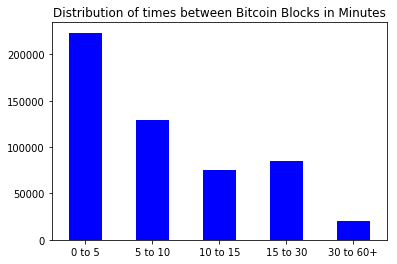

In [0]:
ax = blockgap.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(6,4))
plt.title("Distribution of times between Bitcoin Blocks in Minutes")
ax.set_xticklabels([c.replace(","," to") for c in cleancat])
plt.show()

The Bitcoin network every 2 weeks is adjusted to attempt to keep block times at 10 minutes, but this lags against increasing hashing power in the network. What is very impressive is that >5% of the time, the Bitcoin network will update with a new block within 1 hour!

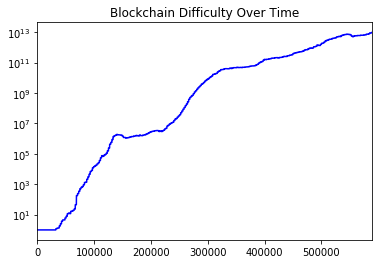

In [0]:
ax = dfcleaned['difficulty'].plot.line(color="b", figsize=(6,4))
plt.yscale('log')
plt.title("Blockchain Difficulty Over Time")
plt.show();

This shows the gradual increase in the difficulty of the bitcoin network adjusting over time.

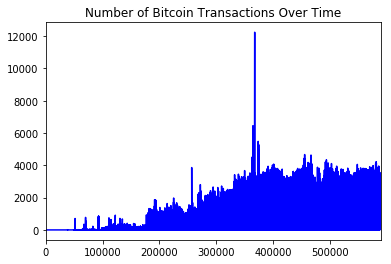

In [0]:
ax = dfcleaned['nTx'].plot.line(color="b", figsize=(6,4))
#plt.yscale('log')
plt.title("Number of Bitcoin Transactions Over Time")
plt.show();

Over time we have an increase in bitcoin transactions, attributed to maximum transaction increases (blocksize increases), and increase popularity in the network.

This notebook is only the beginging of how data can be visualized and evaluated. If you have any questions, please don't hesitate to reach out to me on Twitter @Rob1Ham!